Import libraries

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [57]:
df = pd.read_csv("/content/PS_20174392719_1491204439457_log.csv")

In [58]:
df.head()

,amount,type,old_balance,new_balance,confidence,prediction
0,200.0,2,20000.0,200.0,0.0,✅ SAFE TRANSACTION
1,200.0,3,20000.0,0.0,1.0,🚨 FRAUD DETECTED!
2,200.0,2,20000.0,0.0,1.0,🚨 FRAUD DETECTED!
3,200.0,2,20000.0,0.0,1.0,🚨 FRAUD DETECTED!
4,3000.0,2,20000.0,0.0,1.0,🚨 FRAUD DETECTED!


In [59]:
df.shape


(27, 6)

In [60]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   amount       27 non-null     float64
 1   type         27 non-null     int64  
 2   old_balance  27 non-null     float64
 3   new_balance  27 non-null     float64
 4   confidence   27 non-null     float64
 5   prediction   27 non-null     object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ KB


In [61]:
df.isnull().sum()



,0
amount,0
type,0
old_balance,0
new_balance,0
confidence,0
prediction,0


In [62]:
df['confidence'].value_counts(normalize=True) * 100

,proportion
confidence,
0.00,40.740741
1.00,33.333333
0.01,18.518519
0.87,3.703704
0.84,3.703704


In [63]:
# df = df.drop(['nameOrig', 'nameDest'], axis=1)
df.head()

,amount,type,old_balance,new_balance,confidence,prediction
0,200.0,2,20000.0,200.0,0.0,✅ SAFE TRANSACTION
1,200.0,3,20000.0,0.0,1.0,🚨 FRAUD DETECTED!
2,200.0,2,20000.0,0.0,1.0,🚨 FRAUD DETECTED!
3,200.0,2,20000.0,0.0,1.0,🚨 FRAUD DETECTED!
4,3000.0,2,20000.0,0.0,1.0,🚨 FRAUD DETECTED!


In [64]:
df = df.drop_duplicates()


Remove impossible transactions

In [65]:
df = df[~((df['old_balance'] == 0) &
          (df['new_balance'] == 0) &
          (df['amount'] > 0))]

Remove transactions with all zero values

In [66]:
df = df[(df[['amount','old_balance','new_balance']].sum(axis=1) != 0)]

In [67]:
df.shape


(21, 6)

In [68]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
amount,21.0,1047.619048,1632.672364,100.0,200.0,200.00,1000.0,6000.0
type,21.0,2.857143,1.014185,1.0,2.0,3.00,3.0,5.0
old_balance,21.0,7709.190476,10166.263825,0.0,200.0,2000.00,20000.0,29709.0
new_balance,21.0,3281.714286,6238.958320,0.0,0.0,200.00,5000.0,21270.0
confidence,21.0,0.329048,0.473475,0.0,0.0,0.01,1.0,1.0


#EDA


 Class Distribution

<Axes: xlabel='confidence', ylabel='count'>

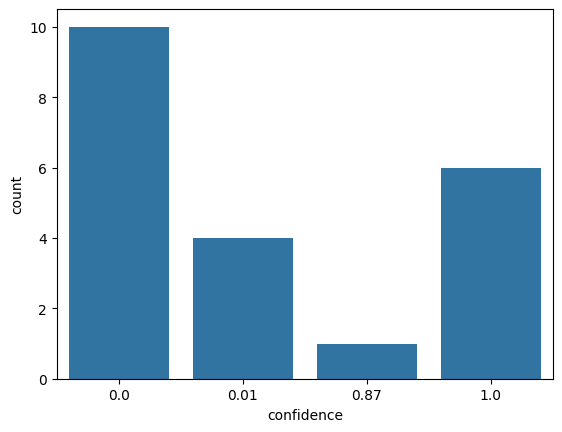

In [69]:
import seaborn as sns
sns.countplot(x='confidence', data=df)

Transaction Type Distribution

<Axes: xlabel='count', ylabel='type'>

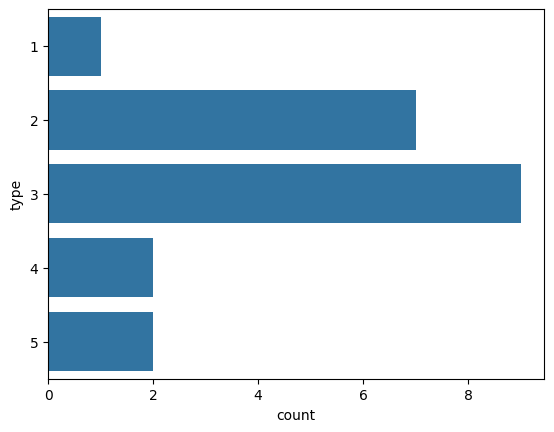

In [70]:
sns.countplot(y='type', data=df)


Correlation Matrix

<Axes: >

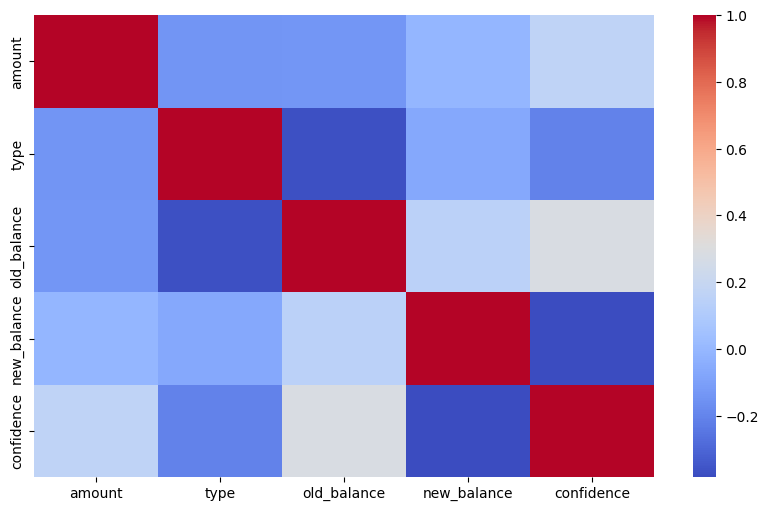

In [71]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Make a copy to avoid modifying the original dataframe for correlation calculation
df_encoded = df.copy()

# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to the 'type' column
df_encoded['type'] = le.fit_transform(df_encoded['type'])

# Drop the 'prediction' column as it's non-numeric
df_encoded = df_encoded.drop('prediction', axis=1)

plt.figure(figsize=(10,6))
sns.heatmap(df_encoded.corr(), annot=False, cmap='coolwarm')

Compare Amount in Fraud vs Non-Fraud

<Axes: xlabel='confidence', ylabel='amount'>

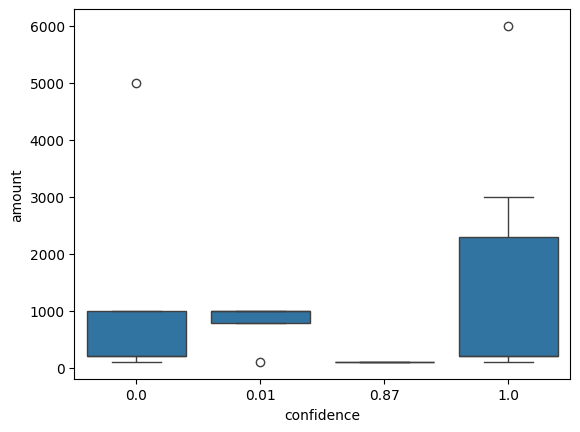

In [72]:
sns.boxplot(x='confidence', y='amount', data=df)

Feature Distributions


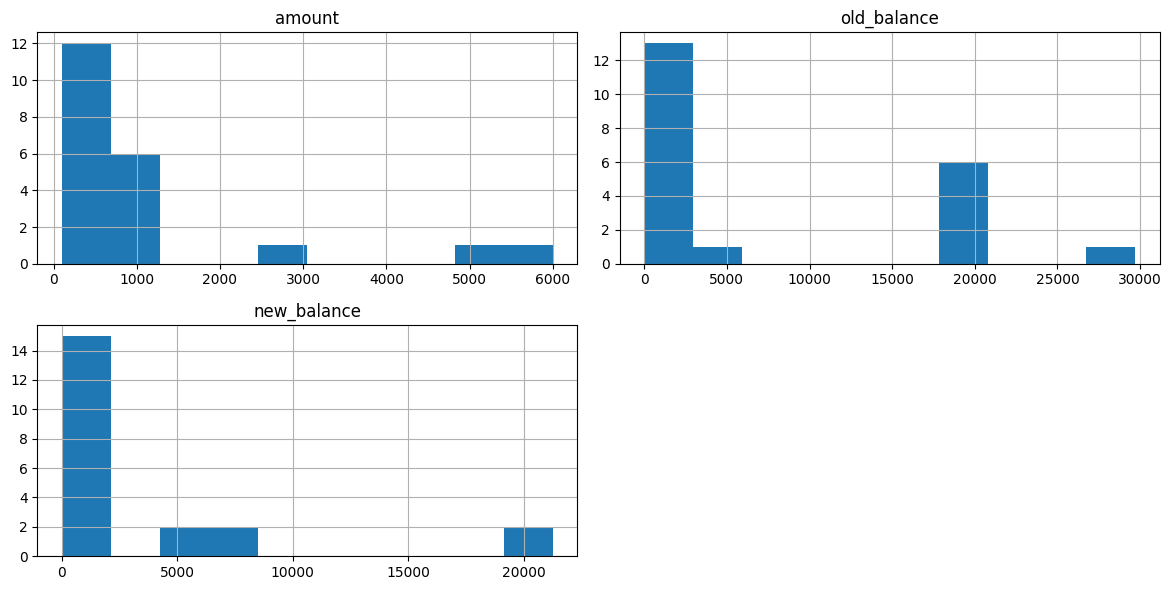

In [73]:
df[['amount','old_balance','new_balance']].hist(figsize=(12,6))
plt.tight_layout()
plt.show()

Detect Outliers

<Axes: >

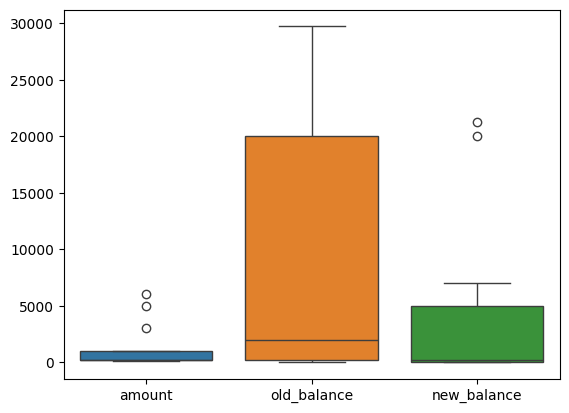

In [74]:
sns.boxplot(data=df[['amount','old_balance','new_balance']])

Fraud by Transaction Type


In [75]:
fraud_by_type = df.groupby('type')['confidence'].mean() * 100
fraud_by_type.sort_values(ascending=False)

,confidence
type,
1,100.000000
5,50.500000
2,42.857143
3,21.111111
4,0.000000


In [76]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])


In [77]:
df['errorBalanceOrig'] = df['new_balance'] + df['amount'] - df['old_balance']
# df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

Train-Test Split

In [78]:
X = df.drop(['confidence', 'prediction'], axis=1)
y = df['confidence']

In [79]:
from sklearn.model_selection import train_test_split

# Binarize the target variable y for stratification
y_binary = (y > 0).astype(int) # This maps all non-zero confidence to 1 (fraud), and 0.0 to 0 (not fraud)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

In [80]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [81]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)


In [82]:
import numpy as np
unique, counts = np.unique(y_train_resampled, return_counts=True)
dict(zip(unique, counts))


{np.int64(0): np.int64(8), np.int64(1): np.int64(8)}

#Model Training & Evaluation Pipeline

Train a Baseline Model (Random Forest)

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Train model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5


ROC-AUC Score: 1.0


Confusion Matrix Visualization

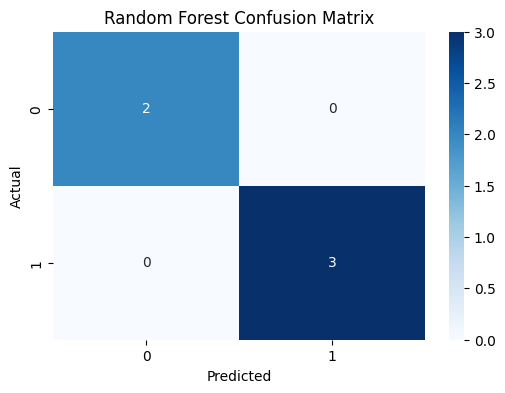

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Improved Model: XGBoost

In [85]:
!pip install xgboost


In [86]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    max_depth=10,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=10,
    random_state=42
)

xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_xgb))


Accuracy: 0.8

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.75      1.00      0.86         3

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5


ROC-AUC Score: 0.75


Compare Model Performance

In [87]:
results = {
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred),
        roc_auc_score(y_test, y_pred_xgb)
    ]
}

pd.DataFrame(results)


,Model,Accuracy,ROC-AUC
0,Random Forest,1.0,1.00
1,XGBoost,0.8,0.75


In [88]:
import joblib

joblib.dump(xgb_model, "fraud_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']